# Import


In [ ]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

import moabb
import mne
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")
warnings.filterwarnings("ignore")

# Instantiate dataset

**Datased used is BCI Competition IVa**


In [21]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

# Create pipelines

**1** - CSP + SVM  
**2** - PSD + LDA


In [ ]:
pipelines = {
    "csp+svm": make_pipeline(CSP(n_components=6), SVC(kernel="linear")),
    "psd+lda": make_pipeline(

        PSDEstimator(fmin=7, fmax=31, sfreq=250),
        FunctionTransformer(lambda X: X.reshape(X.shape[0], -1)),
        LDA(),
    ),

}

# Evaluate


In [26]:
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=[dataset], overwrite=True)
results = evaluation.process(pipelines)
results[results["session"] == "1test"]

2025-07-04 10:06:13,553 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]2025-07-04 10:06:15,948 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 0train: Score 0.952
2025-07-04 10:06:16,317 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 1 | 1test: Score 0.974
2025-07-04 10:06:17,078 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 0train: Score 0.791
2025-07-04 10:06:17,871 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 1 | 1test: Score 0.691
BNCI2014-001-CrossSession:  11%|█         | 1/9 [00:04<00:35,  4.44s/it]2025-07-04 10:06:20,361 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 0train: Score 0.551
2025-07-04 10:06:20,713 INFO MainThread moabb.evaluations.base csp+svm | BNCI2014-001 | 2 | 1test: Score 0.628
2025-07-04 10:06:21,445 INFO MainThread moabb.evaluations.base psd+lda | BNCI2014-001 | 2 | 0train:

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
1,0.974151,0.248005,144.0,1,1test,22,2,BNCI2014-001,csp+svm
3,0.628086,0.237005,144.0,2,1test,22,2,BNCI2014-001,csp+svm
5,0.993441,0.231977,144.0,3,1test,22,2,BNCI2014-001,csp+svm
7,0.836227,0.233975,144.0,4,1test,22,2,BNCI2014-001,csp+svm
9,0.611690,0.229978,144.0,5,1test,22,2,BNCI2014-001,csp+svm
11,0.783565,0.258039,144.0,6,1test,22,2,BNCI2014-001,csp+svm
13,0.885417,0.262973,144.0,7,1test,22,2,BNCI2014-001,csp+svm
15,0.994792,0.240982,144.0,8,1test,22,2,BNCI2014-001,csp+svm
17,0.970100,0.252856,144.0,9,1test,22,2,BNCI2014-001,csp+svm
19,0.690779,0.667017,144.0,1,1test,22,2,BNCI2014-001,psd+lda


# Plot


(0.5, 1.0)

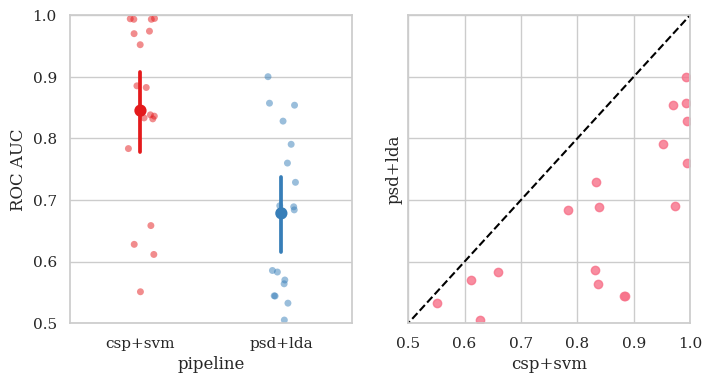

In [28]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="Set1")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(values="score", columns="pipeline", index=["subject", "session"])
paired = paired.reset_index()

sns.regplot(data=paired, y="psd+lda", x="csp+svm", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)